# <center>Apple stock price prediction</center>

Historical apple stock price data were obtained from Apple Inc. (AAPL), Currency in USD at finance.yahoo.com [1].

In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
import tqdm
import random
import sklearn
import math
from sklearn.model_selection import train_test_split, TimeSeriesSplit
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, precision_score
from sklearn.linear_model import LinearRegression
from statsmodels.tsa.stattools import adfuller, acf, kpss
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from datetime import datetime, timezone, timedelta
import six
import sys
import pickle
sys.modules['sklearn.externals.six'] = six
from statsmodels.tsa.arima.model import ARIMA
import statsmodels.api as sm
mpl.rcParams['figure.dpi']=120
plt.rcParams["font.family"] = "arial"
import warnings
warnings.filterwarnings('ignore')
warnings.simplefilter('ignore')
from yahoofinancials import YahooFinancials
from sklearn.metrics import roc_curve, confusion_matrix, classification_report, roc_auc_score
############################################
# Define a function to load data from yahoo
############################################
def get_finance(ticker, start_date='2007-12-31'):
    """Download finance data from finance.yahoo.com"""
    data0=pd.DataFrame(YahooFinancials(ticker).get_historical_price_data(start_date=start_date, 
        end_date=datetime.today().strftime('%Y-%m-%d'), 
        time_interval='daily')[ticker]['prices'])
    data0['Date']=pd.to_datetime(data0['formatted_date'])
    data=data0.drop(columns=['date', 'formatted_date']).set_index('Date')
    return data
############################################
# Prediction functions
############################################
############################################
# Defind a function to calculate RMSE
############################################
def RMSE(prices):
    today_prices=pd.Series([ele.open_price for ele in prices], 
                           index=[ele.datetime for ele in prices]).iloc[1:]
    predicted_prices=pd.Series([ele.predicted_open_price for ele in prices], 
                               index=[ele.predicted_datetime for ele in prices]).iloc[:-1]
    return math.sqrt(mean_squared_error(today_prices, predicted_prices)) 
######################################
# Function to return RMSE against time
######################################
def RMSET(prices):
    return pd.Series([RMSE(prices[:n]) for n in range(2, len(prices))], 
                     index=[ele.datetime for ele in prices][1:-1])
######################################
# Function to tell rising precision
######################################
def precision(prices):
    dataframe=pd.DataFrame({'open': pd.Series([ele.open_price for ele in prices], 
                           index=[ele.datetime for ele in prices]).iloc[1:],
                           'predicted': pd.Series([ele.predicted_open_price for ele in prices], 
                               index=[ele.predicted_datetime for ele in prices]).iloc[:-1]})
    dataframe['real_rise']=np.nan
    dataframe['predicted_rise']=np.nan
    for index, row in dataframe.iterrows():
        if index==dataframe.index[-1]:break
        index_number=dataframe.index.get_loc(index)
        row['real_rise']=dataframe['open'].iloc[index_number+1]-row['open']
        row['predicted_rise']=dataframe['predicted'].iloc[index_number+1]-row['open']
    dataframe=dataframe.dropna()
    dataframe['bool_real_rise']=dataframe['real_rise'].apply(lambda x: 1 if x>0 else 0)
    dataframe['bool_predicted_rise']=dataframe['predicted_rise'].apply(lambda x: 1 if x>0 else 0)
    return precision_score(dataframe['bool_real_rise'], dataframe['bool_predicted_rise'])
#######################################
def plot_predicted_prices(prices, ax):
    dataframe=pd.DataFrame({'open': pd.Series([ele.open_price for ele in prices], 
                           index=[ele.datetime for ele in prices]).iloc[1:],
                           'predicted': pd.Series([ele.predicted_open_price for ele in prices], 
                               index=[ele.predicted_datetime for ele in prices]).iloc[:-1]})
    for index, row in dataframe.iterrows():
        if index==dataframe.index[-1]:break
        index_number=dataframe.index.get_loc(index)
        if row['open']<dataframe['predicted'].iloc[index_number+1]:
            color='g'
        else:
            color='r'
        _=ax.plot([index, dataframe.index[index_number+1]], 
                  [row['open'], dataframe['predicted'].iloc[index_number+1]],
                  c=color)
########################################
def report(prices):
    dataframe=pd.DataFrame({'open': pd.Series([ele.open_price for ele in prices], 
                           index=[ele.datetime for ele in prices]).iloc[1:],
                           'predicted': pd.Series([ele.predicted_open_price for ele in prices], 
                               index=[ele.predicted_datetime for ele in prices]).iloc[:-1]})
    dataframe['real_rise']=np.nan
    dataframe['predicted_rise']=np.nan
    for index, row in dataframe.iterrows():
        if index==dataframe.index[-1]:break
        index_number=dataframe.index.get_loc(index)
        row['real_rise']=dataframe['open'].iloc[index_number+1]-row['open']
        row['predicted_rise']=dataframe['predicted'].iloc[index_number+1]-row['open']
    dataframe=dataframe.dropna()
    dataframe['bool_real_rise']=dataframe['real_rise'].apply(lambda x: 1 if x>0 else 0)
    dataframe['bool_predicted_rise']=dataframe['predicted_rise'].apply(lambda x: 1 if x>0 else 0)
    print('-----------------------------------------------------------------------')
    cm=confusion_matrix(dataframe['bool_real_rise'], dataframe['bool_predicted_rise'])
    conf_matr=pd.DataFrame({' ': ['True Positive', 'False Negative', 'False Positive', 'True Negative'],
                       'Count': [cm[1, 1], cm[1, 0], cm[0, 1], cm[0, 0]]}).set_index(' ').T
    print(conf_matr)
    print('-----------------------------------------------------------------------')
    print(classification_report(dataframe['bool_real_rise'], dataframe['bool_predicted_rise']))
    print('-----------------------------------------------------------------------')
############################################
class Stock(object):
    def __init__(self, datetime, open_price, predicted_datetime, predicted_open_price):
        self.datetime=datetime
        self.open_price=open_price
        self.predicted_datetime=predicted_datetime
        self.predicted_open_price=predicted_open_price
################################
def sarimax_predict(y_train, y_test, params):
    """params=(p, d, q, P, D, Q, s, weekday, interval)"""
    p, d, q, P, D, Q, s, weekday, interval=params
    stock_prices=list()
    y_train_moving=y_train.copy()
    flag=False
    count=0
    for index, row in y_test.iterrows():
        y_train_moving=y_train_moving.append(pd.DataFrame({'open': [row[0]]}, index=[index]))
        if index.weekday()==weekday:
            flag=True
        if flag and count%interval==0:
            model_moving=sm.tsa.SARIMAX(y_train_moving, order=(p, d, q), seasonal_order=(P, D, Q, s)).fit()
            y_prediction=model_moving.predict(start=len(y_train_moving.index), 
                                              end=len(y_train_moving.index)+interval)
            stock_prices.append(Stock(index, row[0], index+timedelta(interval), y_prediction.values[-1]))
        count+=1
    ###############################
    # return stock prices
    ###############################
    return stock_prices

We firstly downloaded the data, then we selected open price as dependent variable for prediction.

In [7]:
apple0=get_finance('AAPL', start_date='2000-08-30')
##########################
# Delete Missing values
##########################
apple=apple0.dropna()
pd.DataFrame({' ' : ['Value'],
             'Original number of rows': [apple0.shape[0]],
             'Final number of rows': [apple.shape[0]],
             'Number of rows with NaN': [apple0.shape[0]-apple.shape[0]],
             'NaN rate': ['{:.2f}%'.format((apple0.shape[0]-apple.shape[0])/apple0.shape[0]*100)]}).set_index(' ').T

,Value
Original number of rows,5189
Final number of rows,5189
Number of rows with NaN,0
NaN rate,0.00%


In [8]:
# Describe of the data set.
apple.tail()

,high,low,open,close,volume,adjclose
Date,,,,,,
2021-04-12,132.850006,130.630005,132.520004,131.240005,91420000,131.240005
2021-04-13,134.660004,131.929993,132.440002,134.429993,91266500,134.429993
2021-04-14,135.000000,131.660004,134.940002,132.029999,87222800,132.029999
2021-04-15,135.000000,133.639999,133.820007,134.500000,89347100,134.500000
2021-04-16,134.669998,133.279999,134.300003,134.160004,84818500,134.160004


We focus on open prices as dependent variable, and subset the open column.

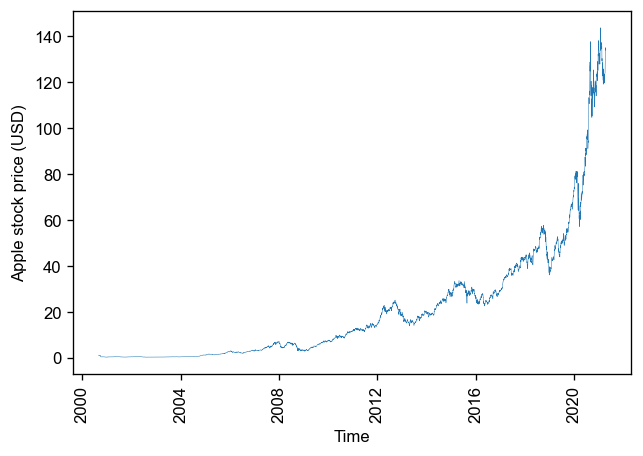

In [9]:
fig, ax=plt.subplots(1, 1)
ax.plot(apple[['open']], linewidth=0.3)
ax.set_xlabel('Time')
ax.set_ylabel('Apple stock price (USD)')
plt.xticks(rotation=90)
plt.show()

In [10]:
#############################################################
# Test whether apple stock price time series is random walk
#############################################################
adfuller_result=adfuller(apple['open'].diff().dropna())
pd.DataFrame({' ': ['Value'], 'ADF Statistic:': ['{:.3f}'.format(adfuller_result[0])],
             'p-value:': ['{:.9f}'.format(adfuller_result[1])],
              'Critical Values 1%:': ['{:.3f}'.format(list(adfuller_result[4].values())[0])],
              'Critical Values 5%:': ['{:.3f}'.format(list(adfuller_result[4].values())[1])],
              'Critical Values 10%:': ['{:.3f}'.format(list(adfuller_result[4].values())[2])]
             }).set_index(' ').T

,Value
ADF Statistic:,-12.054
p-value:,0.000000000
Critical Values 1%:,-3.432
Critical Values 5%:,-2.862
Critical Values 10%:,-2.567


With an extremely small p-value from an Augmented Dickey-Fuller test on the first order difference (the return) of the apple stock price time series, we can reject the null hypothesis of random walk, and conclude that the time series is not a random walk. It is possible to predict the apple stock price!

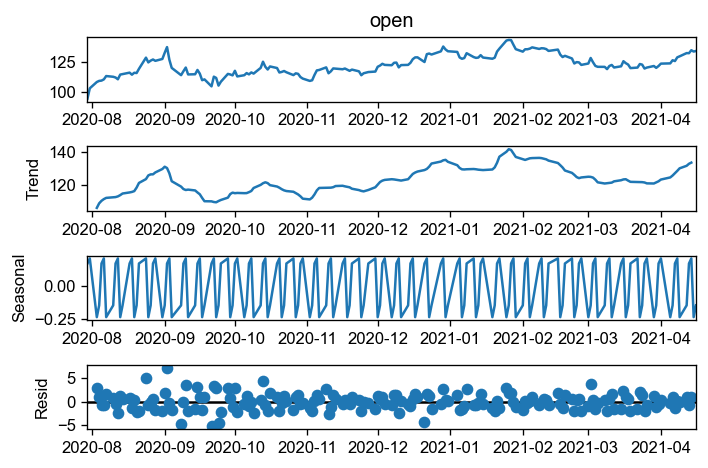

In [11]:
#####################################################################
# Decompose the apple stock price time series
#####################################################################
seasonal_decompose(apple['open'].iloc[-180:], model='linear', period=4).plot()
plt.show()

It seems that the apple stock price has a seasonal component. It may due to a mean reversion: when the price gets higher, people want to sell, causing the price go lower, and then people want to buy, causing the price higher, again and again. The goal of this project is using this mean reversion to make the model profitable (to make prediction by the behavior of apple stock price itself).

Next, we are going to find out if the apple stock price return time series is stationary. 

In [12]:
#########################################################
# Use kpss to tell if apple stock return is stationary
#########################################################
pd.DataFrame({' ': ['p-value'], 
             '1 order of difference': [kpss(apple['open'].diff().dropna())[1]],
             '2 order of difference': [kpss(apple['open'].diff().dropna().diff().dropna())[1]]}).set_index(' ').T

,p-value
1 order of difference,0.01
2 order of difference,0.10


We can see that the apple stock return is not stationary. However, second order of difference (the difference of the return) makes the apple stock price stationary.

We will use ACF and PACF to tell which AR or MA model can fit the apple stock price time series.

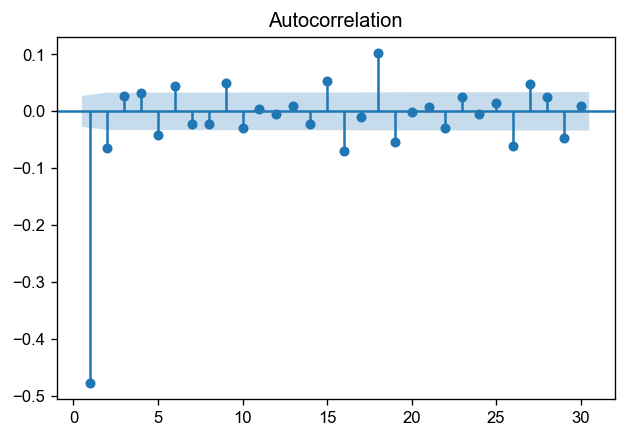

In [13]:
###################################################################################################################
# Autocorrelation investigation for apple stock price (95% confidence interval)
###################################################################################################################
_=plot_acf(apple['open'].diff().dropna().diff().dropna(), lags=30, zero=False, alpha=0.05)
plt.show()

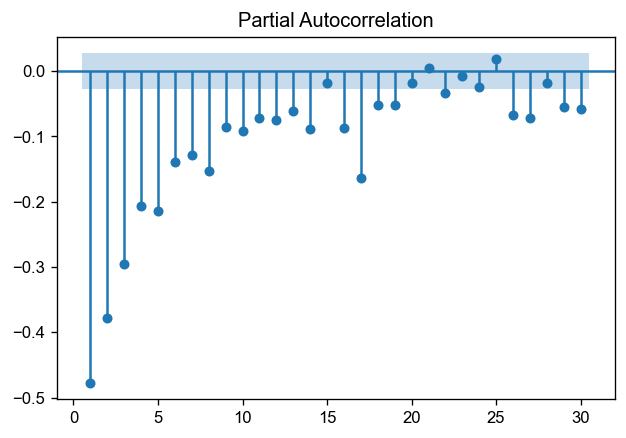

In [14]:
_=plot_pacf(apple['open'].diff().dropna().diff().dropna(), lags=30, zero=False, alpha=0.05)
plt.show()

The ACF cuts off after lag 1, and PACF tails off, indicating a MA(1) model ($q$=1). Because the second order of difference can make the apple stock price stationary, the order of differencing $d$=2. $p$ should be zero but we are going to do a hyperparameter optimization to further determine the values of $p$, $d$, and $q$. 

We are going to use an Autoregressive Integrated Moving Averages (ARIMA) model to fit and predict the apple stock prices. ARIMA is well-known for forecasting stocks and financial market fluctuations, and data scientists and researchers have been utilizing ARIMA model to predict the price of gold [1,6]. Without helps of exogenous variables, we will see how good our prediction will be.

The goal of this project is to be profitable. We want this model be able to tell us, in a certain time window, is the price going up or down. The model is going to be indicative for us whether we should bull the market or do short sale for the stock within several business days. Long-term prediction is not in the scope of this project.

In [16]:
####################################################
# Fill missing dates
####################################################
Y=apple[['open']]
Y=Y.resample('D').ffill()
Y.tail()
###############################################
# Train-test split
###############################################
y_train=Y.loc[Y.index<pd.to_datetime("2018", format='%Y')]
y_test=Y.loc[Y.index>=pd.to_datetime("2018", format='%Y')]
print(y_train.shape)
print(y_test.shape)

(6333, 1)
(1202, 1)


In [ ]:
##########################################################################################
# Use train set to do cross validation hyperparameter tunning - random search
##########################################################################################
random.seed(3)
#################################################
# params=(p, d, q, P, D, Q, s, weekday, interval)
#################################################
PARAMS=list(set([(
    random.sample([1, 2], 1)[0], random.sample([1, 2], 1)[0], 
    random.sample([1, 2], 1)[0], random.sample([0, 1, 2, 3], 1)[0], 
    random.sample([0, 1, 2, 3], 1)[0], random.sample([0, 1, 2, 3], 1)[0],
    random.sample([2, 3, 4, 5, 6, 7, 8, 9], 1)[0],
    random.sample([0, 1, 2, 3, 4, 5, 6], 1)[0], 
    random.sample([1, 2, 3, 4, 5, 6, 7, 8, 9, 10], 1)[0]) for i in range(100)]))
results=pd.DataFrame(columns=['params', 'RMSE list', 'mean RMSE', 'precision list', 'mean precision'])
index=0
for params in tqdm.tqdm(PARAMS):
    try:
        RMSE_list=[]
        precision_list=[]
        for train_index, test_index in TimeSeriesSplit(n_splits=5).split(y_train):
            y_train_train, y_train_test=y_train.iloc[train_index], y_train.iloc[test_index]
            prices=sarimax_predict(y_train_train, y_train_test, params=params)
            RMSE_list.append(RMSE(prices))
            precision_list.append(precision(prices))        
        results=results.append(pd.DataFrame({'params': [params], 
                    'RMSE list': [['{:.2f}'.format(ele) for ele in RMSE_list]],
                    'mean RMSE': [np.mean(RMSE_list)],
                    'precision list': [['{:.2f}'.format(ele) for ele in precision_list]],
                    'mean precision': [np.mean(precision_list)]}, index=[index]))
        index+=1
    except:
        pass
#####################################################
results.sort_values(by=['mean precision', 'mean RMSE'], ascending=[False, True]).head()

  0%|          | 0/100 [00:00<?, ?it/s]

In [ ]:
######################################
# Apply the best model on test data
######################################
test_prices_sarimax=sarimax_predict(y_train, y_test, params=(1, 1, 2, 3, 0, 0, 7, 1))
print('Prediction precision is {:.2f}%'.format(precision(test_prices_sarimax)*100))
##############################################
# Plot predict result on test set
##############################################
report(test_prices_sarimax)
fig, (ax1, ax2)=plt.subplots(1, 2, figsize=(12, 4))
open_prices=pd.Series([ele.open_price for ele in test_prices_sarimax], 
                      index=[ele.datetime for ele in test_prices_sarimax]).iloc[1:]
predicted_prices=pd.Series([ele.predicted_open_price for ele in test_prices_sarimax], 
                           index=[ele.predicted_datetime for ele in test_prices_sarimax]).iloc[:-1]
_=ax1.plot(open_prices,
        label='Open prices', c=(212/255, 175/255, 55/255))
_=plot_predicted_prices(test_prices_sarimax, ax1)
for tick in ax1.get_xticklabels():
    tick.set_rotation(90)
_=ax1.set_xlabel('Time')
_=ax1.set_ylabel('Stock price (USD)')
_=ax1.legend(frameon=False)
_=ax1.set_xlim([open_prices.index[0], open_prices.index[-1]])
_=ax2.plot(RMSET(test_prices_sarimax))
_=ax2.tick_params(labelrotation=90)
_=ax2.set_ylabel('RMSE (USD)')
for tick in ax2.get_xticklabels():
    tick.set_rotation(90)
_=ax2.set_xlabel('Time')
plt.show()

In [11]:
##########################################################################################
# Use train and validation sets to do hyperparameter tunning - random search
##########################################################################################
# Define a loss function: we want the model to predict rise or fall of prices correctly
# so f1-score for true prediction (rise) as the metric, the bigger the better
##########################################################################################
def loss(y_train, y_validation, params):
    """Loss function for apple stock price model. params=(p, d, q, P, D, Q, s, day)"""
    y_train_moving=y_train.copy()
    prediction_results=pd.DataFrame(columns=['real', 'predict'])
    p, d, q, P, D, Q, s, day=params
    count=0
    last_index=y_train_moving.index[-1]
    real_value=y_train['open'].iloc[-1]
    for index, row in y_validation.iterrows():
        y_train_moving=y_train_moving.append(pd.DataFrame({'open': [row[0]]}, index=[index]))
        if count%day==0:
            try:
                model_moving=sm.tsa.SARIMAX(y_train_moving, order=(p, d, q), seasonal_order=(P, D, Q, s)).fit()
                y_prediction=model_moving.predict(start=len(y_train_moving.index), end=len(y_train_moving.index)+day)
                prediction=pd.DataFrame({'Prediction': [real_value, y_prediction.values[-1]]}, 
                                    index=[last_index, index])
                last_index=index
                real_value=row[0]
                prediction_results=prediction_results.append(pd.DataFrame(
                    {'real': [y_train_moving['open'].iloc[-1]-y_train_moving['open'].iloc[-(day+1)]],
                     'predict': [prediction['Prediction'].iloc[-1]-y_train_moving['open'].iloc[-(day+1)]]},
                                                        index=[y_train_moving.index[-1]]))
            except:
                return np.nan
        count+=1
    ###################################################
    # Summary the prediction result
    ###################################################
    prediction_results['bool_real']=prediction_results['real'].apply(lambda x: 1 if x>0 else 0)
    prediction_results['bool_predict']=prediction_results['predict'].apply(lambda x: 1 if x>0 else 0)
    report=classification_report(prediction_results['bool_real'], prediction_results['bool_predict'])
    return float([ele for ele in report.split('\n')[3].split(' ') if ele][3]) # F1-score for 1

In [12]:
########################################
# Random search hyperparameter tuning
########################################
"""
params_pool=list(set([(np.random.randint(0, 3), 
         np.random.randint(0, 3), 
         np.random.randint(0, 3),
         np.random.randint(0, 3),
         np.random.randint(0, 3),
         np.random.randint(0, 3),
         np.random.randint(0, 8),
         np.random.randint(0, 8)) for i in range(10)]))
params_list=[]
f1_score=[]
for params in params_pool:
    params_list.append(params)
    f1_score.append(loss(y_train, y_validation, params))
results=pd.DataFrame({'params': params_list, 'f1_score': f1_score}).sort_values('f1_score', ascending=False)
results.head() """

"\nparams_pool=list(set([(np.random.randint(0, 3), \n         np.random.randint(0, 3), \n         np.random.randint(0, 3),\n         np.random.randint(0, 3),\n         np.random.randint(0, 3),\n         np.random.randint(0, 3),\n         np.random.randint(0, 8),\n         np.random.randint(0, 8)) for i in range(10)]))\nparams_list=[]\nf1_score=[]\nfor params in params_pool:\n    params_list.append(params)\n    f1_score.append(loss(y_train, y_validation, params))\nresults=pd.DataFrame({'params': params_list, 'f1_score': f1_score}).sort_values('f1_score', ascending=False)\nresults.head() "

params=(1, 1, 1, 2, 0, 0, 5, 6) is a good one

In [13]:
#################################################
# Prediction function
#################################################
def prediction(Y, y_train, y_test, params, start_time=Y.index[0]):
    y_train_moving=y_train.copy()
    prediction_results=pd.DataFrame(columns=['real', 'predict'])
    p, d, q, P, D, Q, s, day=params
    ##########################################
    # Plot
    ##########################################
    fig, ax=plt.subplots(1, 1)
    ax.plot(Y.index, Y['open'], label='Open Price', linewidth=0.5)
    ##########################################
    count=0
    last_index=y_train_moving.index[-1]
    real_value=y_train['open'].iloc[-1]
    for index, row in y_test.iterrows():
        y_train_moving=y_train_moving.append(pd.DataFrame({'open': [row[0]]}, index=[index]))
        if count%day==0:
            model_moving=sm.tsa.SARIMAX(y_train_moving, order=(p, d, q), seasonal_order=(P, D, Q, s)).fit()
            y_prediction=model_moving.predict(start=len(y_train_moving.index), end=len(y_train_moving.index)+day)
            prediction=pd.DataFrame({'Prediction': [real_value, y_prediction.values[-1]]}, 
                                index=[last_index, index])
            last_index=index
            real_value=row[0]
            ax.plot(prediction, alpha=0.7, linewidth=0.5, c='r')
            prediction_results=prediction_results.append(pd.DataFrame(
                {'real': [y_train_moving['open'].iloc[-1]-y_train_moving['open'].iloc[-(day+1)]],
                 'predict': [prediction['Prediction'].iloc[-1]-y_train_moving['open'].iloc[-(day+1)]]},
                                                    index=[y_train_moving.index[-1]]))
        count+=1
    ###################################################
    # Summary the prediction result
    ###################################################
    prediction_results['bool_real']=prediction_results['real'].apply(lambda x: 1 if x>0 else 0)
    prediction_results['bool_predict']=prediction_results['predict'].apply(lambda x: 1 if x>0 else 0)
    cm=confusion_matrix(prediction_results['bool_real'], prediction_results['bool_predict'])
    print(pd.DataFrame({' ': ['True Positive', 'False Negative', 'False Positive', 'True Negative'],
                           'Count': [cm[1, 1], cm[1, 0], cm[0, 1], cm[0, 0]]}).set_index(' ').T)
    print(classification_report(prediction_results['bool_real'], prediction_results['bool_predict']))
    ###################################################
    # Predict the future
    ###################################################
    model_moving=sm.tsa.SARIMAX(y_train_moving, order=(p, d, q), seasonal_order=(P, D, Q, s)).fit()
    y_prediction=model_moving.predict(start=len(y_train_moving.index), end=len(y_train_moving.index)+day)
    print('Current apple stock open price is ${:.2f}'.format(y_test['open'].iloc[-1]))
    print('Predicted apple stock open price after {} days is ${:.2f}'.format(day, y_prediction.values[-1]))
    print('Price change is ${:.2f}'.format(y_prediction.values[-1]-y_test['open'].iloc[-1]))
    prediction=pd.DataFrame({'Prediction': [y_test['open'].iloc[-1], y_prediction.values[-1]]}, 
                                index=[y_test.index[-1], y_test.index[-1]+timedelta(day)])
    ax.plot(prediction, alpha=0.7, linewidth=0.5, c='r')
    ax.set_xlabel('Time')
    ax.set_ylabel('Apple stock price (USD)')
    ax.legend(frameon=False)
    plt.xticks(rotation=90)
    ax.set_xlim([start_time, y_test.index[-1]+timedelta(day)])
    plt.show()
####################################################################

       True Positive  False Negative  False Positive  True Negative
Count            103               0               0             80
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        80
           1       1.00      1.00      1.00       103

    accuracy                           1.00       183
   macro avg       1.00      1.00      1.00       183
weighted avg       1.00      1.00      1.00       183

Current apple stock open price is $39.63
Predicted apple stock open price after 6 days is $39.54
Price change is $-0.09


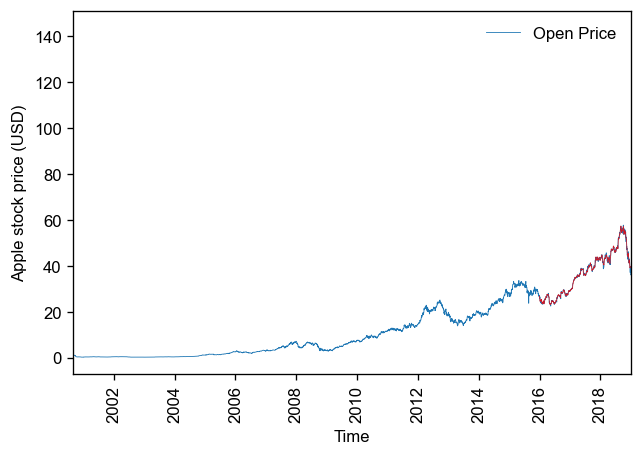

In [14]:
########################################
# Test on the validate set
########################################
params=(1, 1, 1, 2, 0, 0, 5, 6)
_=prediction(Y, y_train, y_validation, params, start_time=Y.index[0])

       True Positive  False Negative  False Positive  True Negative
Count             90               1               2             47
              precision    recall  f1-score   support

           0       0.98      0.96      0.97        49
           1       0.98      0.99      0.98        91

    accuracy                           0.98       140
   macro avg       0.98      0.97      0.98       140
weighted avg       0.98      0.98      0.98       140

Current apple stock open price is $134.94
Predicted apple stock open price after 6 days is $134.47
Price change is $-0.47


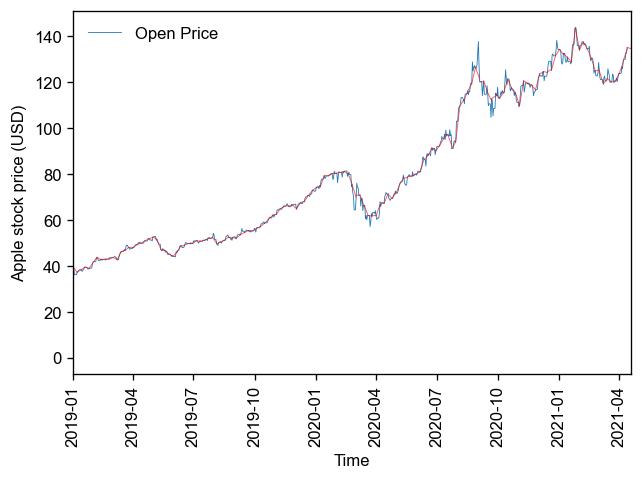

In [15]:
##########################################################
# Now use this model on test set to see how it gererates
##########################################################
y_train=Y.loc[Y.index<pd.to_datetime("2019", format='%Y')]
y_test=Y.loc[Y.index>=pd.to_datetime("2019", format='%Y')]
params=(1, 1, 1, 2, 0, 0, 5, 6)
_=prediction(Y, y_train, y_test, params, start_time=pd.to_datetime("2019-01-01", format='%Y-%m-%d'))

Now we have a good model, and the next question is: how to make this model most profitable. In other words, what is our strategy to trade Apple stocks according to the information provided by this model?

In [16]:
###################################
# define stock class
###################################
class Stock(object):
    def __init__(self, time):
        self.time=time
        self.open=np.nan
        self.predict=np.nan        

In [17]:
###############################
# Make a list of apple stocks
###############################
applelist=list()
for index, row in Y.iterrows():
    applelist.append(Stock(index))
    applelist[-1].open=row[0]

In [18]:
##################################################################################################
# First attempt: follow the six day cycle since the six day prediction is accurate
# Assume we start to make money from September 2020 by this model: we want to avoid the huge rise
##################################################################################################
day=6
####################################################################################
y_train=Y.loc[Y.index<pd.to_datetime("2016", format='%Y')]
y_test=Y.loc[Y.index>=pd.to_datetime("2016", format='%Y')]
y_train_moving=y_train.copy()
count=0
last_index=y_train_moving.index[-1]
real_value=y_train['open'].iloc[-1]
for index, row in y_test.iterrows():
    y_train_moving=y_train_moving.append(pd.DataFrame({'open': [row[0]]}, index=[index]))
    if count%day==0:
        model_moving=sm.tsa.SARIMAX(y_train_moving, order=(1, 1, 1), seasonal_order=(2, 0, 0, 5)).fit()
        y_prediction=model_moving.predict(start=len(y_train_moving.index), end=len(y_train_moving.index)+day)
        for stock in applelist:
            if stock.time==index+timedelta(day):
                stock.predict=y_prediction.values[-1]
                break
        last_index=index
        real_value=row[0]
    count+=1

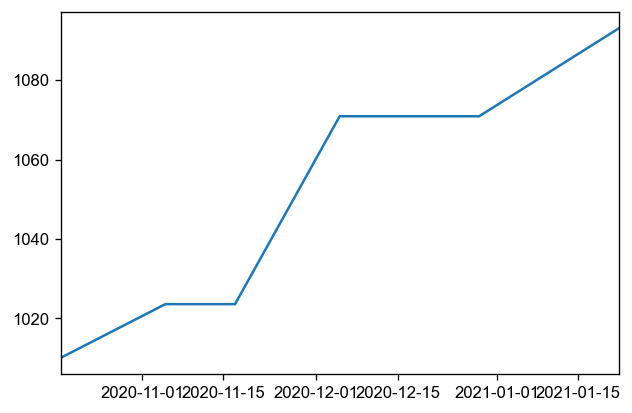

From september 2020 to today, we can earn $93.10


In [19]:
#################################################################################################
# Try different strategy to trade apple stock: simply buy and sell when seeing the predict value
#################################################################################################
applelist2020=[stock for stock in applelist if stock.time>=pd.to_datetime('2020-09', format='%Y-%m')]
money=1000.0
money_trace=[]
time_trace=[]
share=0.0
today_real=0.0
today_predict=0.0
next_predict=0.0
next_real=0.0
last_buy_price=0.0
for index, stock in enumerate(applelist2020):
    if not np.isnan(stock.predict):
        today_real=stock.open
        today_predict=stock.predict
        step=0
        while (index+step)<len(applelist2020)-1:
            step+=1
            if not np.isnan(applelist2020[index+step].predict):
                next_predict=applelist2020[index+step].predict
                next_real=applelist2020[index+step].open
                middle_prices=[]
                for i in range(1, step):
                    middle_prices.append(applelist2020[index+i].open)
                break
        if share<0.1 and today_real<next_predict: #buy
            share=money/today_real
            money=0.0
            last_buy_price=today_real
        if money<0.1 and today_real>next_predict and today_real>last_buy_price: #sell
            money=share*today_real
            share=0.0
        if not money<0.1:
            money_trace.append(money)
            time_trace.append(stock.time)
            
_=plt.plot(time_trace, money_trace)
_=plt.xlim([min(time_trace), max(time_trace)])
plt.show()
print('From september 2020 to today, we can earn ${:.2f}'.format(money_trace[-1]-1000))

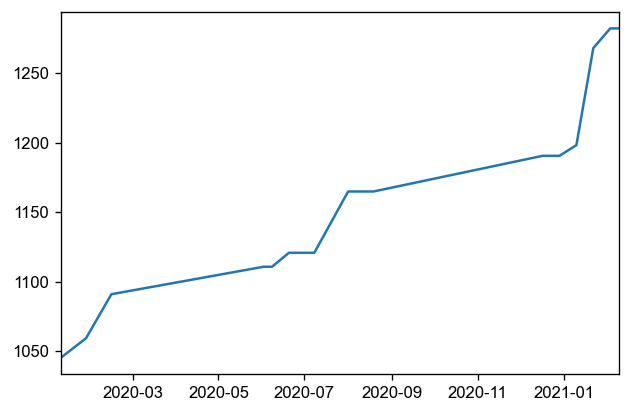

From September 2020 to today, we can earn $282.32


In [20]:
#################################################################################################
# Try different strategy to trade apple stock: find an optimited value to buy and sell
#################################################################################################
applelist2020=[stock for stock in applelist if stock.time>=pd.to_datetime('2020', format='%Y')]
money=1000.0
money_trace=[]
time_trace=[]
share=0.0
today_real=0.0
today_predict=0.0
next_predict=0.0
next_real=0.0
last_buy_price=0.0
for index, stock in enumerate(applelist2020):
    if not np.isnan(stock.predict):
        today_real=stock.open
        today_predict=stock.predict
        step=0
        while (index+step)<len(applelist2020)-1:
            step+=1
            if not np.isnan(applelist2020[index+step].predict):
                next_predict=applelist2020[index+step].predict
                next_real=applelist2020[index+step].open
                middle_prices=[]
                for i in range(1, step):
                    middle_prices.append(applelist2020[index+i].open)
                break
        if share<0.1 and today_real<next_predict: #buy
            if middle_prices[0]>=today_real:
                buy_price=middle_prices[0]
            elif middle_prices[1]>=middle_prices[0]:
                buy_price=middle_prices[1]
            elif middle_prices[2]>=middle_prices[1]:
                buy_price=middle_prices[2]
            elif middle_prices[3]>=middle_prices[2]:
                buy_price=middle_prices[3]
            elif middle_prices[4]>=middle_prices[3]:
                buy_price=middle_prices[4]
            else:
                buy_price=middle_prices[5]
            share=money/buy_price
            money=0.0
            last_buy_price=buy_price
        if money<0.1 and today_real>next_predict: #sell
            if middle_prices[0]<=today_real:
                sell_price=middle_prices[0]
            elif middle_prices[1]<=middle_prices[0]:
                sell_price=middle_prices[1]
            elif middle_prices[2]<=middle_prices[1]:
                sell_price=middle_prices[2]
            elif middle_prices[3]<=middle_prices[2]:
                sell_price=middle_prices[3]
            elif middle_prices[4]<=middle_prices[3]:
                sell_price=middle_prices[4]
            else:
                sell_price=middle_prices[5]
            if sell_price>last_buy_price:
                money=share*sell_price
                share=0.0
        if not money<0.1:
            money_trace.append(money)
            time_trace.append(stock.time)
            
_=plt.plot(time_trace, money_trace)
_=plt.xlim([min(time_trace), max(time_trace)])
plt.show()
print('From September 2020 to today, we can earn ${:.2f}'.format(money_trace[-1]-1000))

### References

[1] https://finance.yahoo.com

